In [7]:
from dotenv import load_dotenv
from langchain_core.output_parsers import PydanticOutputParser
from langchain_community.embeddings import DashScopeEmbeddings

load_dotenv()

True

# Retriever

In [9]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import InMemoryVectorStore
from langchain_text_splitters import RecursiveCharacterTextSplitter

urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=100, chunk_overlap=50
)
doc_splits = text_splitter.split_documents(docs_list)

# Add to vectorDB
embeddings = DashScopeEmbeddings(model="text-embedding-v3")
vectorstore = InMemoryVectorStore.from_documents(
    documents=doc_splits,
    embedding=embeddings,
)
retriever = vectorstore.as_retriever()

In [18]:
from langchain_core.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_blog_posts",
    "Search and return information about Lilian Weng blog posts on LLM agents, prompt engineering, and adversarial attacks on LLMs.",
)

tools = [retriever_tool]

# Agent State

In [19]:
from typing import Annotated, Sequence, Literal
from typing_extensions import TypedDict

from langchain_core.messages import BaseMessage

from langgraph.graph.message import add_messages


class AgentState(TypedDict):
    # The add_messages function defines how an update should be processed
    # Default is to replace. add_messages says "append"
    messages: Annotated[Sequence[BaseMessage], add_messages]

# Nodes and Edges

In [35]:
from langchain_core.messages import HumanMessage
from langchain_core.prompts import PromptTemplate, ChatPromptTemplate
from langchain_openai import ChatOpenAI

from pydantic import BaseModel, Field

from langgraph.prebuilt import tools_condition

In [26]:
def grade_documents(state) -> Literal["generate", "rewrite"]:
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (messages): The current state

    Returns:
        str: A decision for whether the documents are relevant or not
    """

    print("---CHECK RELEVANCE---")

    # Data model
    class grade(BaseModel):
        """Binary score for relevance check."""

        binary_score: Literal["yes", "no"] = Field(
            ..., description="Relevance score 'yes' or 'no'"
        )

    parser = PydanticOutputParser(pydantic_object=grade)

    model = ChatOpenAI(model='qwen-plus')

    # Prompt
    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.\n
        {format_instructions}
        """,
        input_variables=["context", "question"],
    ).partial(format_instructions=parser.get_format_instructions())

    # Chain
    chain = prompt | model | parser

    messages = state["messages"]
    last_message = messages[-1]

    question = messages[0].content
    docs = last_message.content

    scored_result = chain.invoke({"question": question, "context": docs})

    score = scored_result.binary_score

    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generate"

    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        print(score)
        return "rewrite"

In [27]:
def agent(state):
    """
    Invokes the agent model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply end.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with the agent response appended to messages
    """
    print("---CALL AGENT---")

    messages = state["messages"]
    model = ChatOpenAI(temperature=0, streaming=True, model="qwen-max")
    model = model.bind_tools(tools)
    response = model.invoke([messages[-1]])
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

In [41]:
prompt = """
You are an assistant for question-answering tasks.
Use the following pieces of retrieved context to answer the question.
If you don't know the answer, just say you don't know.
Use three sentences maximum and keep the answer concise.

Question: {question}
Context: {context}
Answer:
"""
prompt = ChatPromptTemplate.from_template(prompt)


def rewrite(state):
    """
    Transform the query to produce a better question.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with re-phrased question
    """
    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content
    msg = [
        HumanMessage(
            content=f""" \n 
    Look at the input and try to reason about the underlying semantic intent / meaning. \n 
    Here is the initial question:
    \n ------- \n
    {question} 
    \n ------- \n
    Formulate an improved question, Return only the improved question without any additional information"""
        )
    ]
    # Grader
    model = ChatOpenAI(temperature=0, model="qwen-max", streaming=True)
    response = model.invoke(msg)
    return {"messages": [response]}


def generate(state):
    """
    Generate answer

    Args:
        state (messages): The current state

    Returns:
         dict: The updated state with re-phrased question
    """
    print("---GENERATE---")
    messages = state["messages"]
    question = messages[0].content
    last_message = messages[-1]
    docs = last_message.content

    # LLM
    llm = ChatOpenAI(model_name="qwen-plus", temperature=0, streaming=True)

    # Post-processing
    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)

    # Chain
    rag_chain = prompt | llm

    # Run
    response = rag_chain.invoke({"context": docs, "question": question})
    return {"messages": [response]}

# Graph

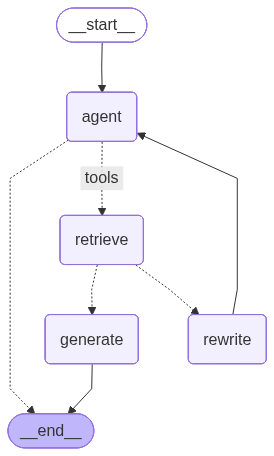

In [42]:
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode

# Define a new graph
workflow = StateGraph(AgentState)

# Define the nodes we will cycle between
workflow.add_node("agent", agent)  # agent
retrieve = ToolNode([retriever_tool])
workflow.add_node("retrieve", retrieve)  # retrieval
workflow.add_node("rewrite", rewrite)  # Re-writing the question
workflow.add_node(
    "generate", generate
)  # Generating a response after we know the documents are relevant
# Call agent node to decide to retrieve or not
workflow.add_edge(START, "agent")
# Decide whether to retrieve
workflow.add_conditional_edges(
    "agent",
    # Assess agent decision
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "retrieve",
        END: END,
    },
)
# Edges taken after the `action` node is called.
workflow.add_conditional_edges(
    "retrieve",
    # Assess agent decision
    grade_documents,
    {
        # Translate the condition outputs to nodes in our graph
        "generate": "generate",
        "rewrite": "rewrite",
    }
)
workflow.add_edge("generate", END)
workflow.add_edge("rewrite", "agent")

# Compile
graph = workflow.compile()
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [43]:
import pprint

inputs = {
    "messages": [
        ("user", "What does Lilian Weng say about the types of agent memory?"),
    ]
}
for output in graph.stream(inputs):
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    print("\n")

---CALL AGENT---
Output from node 'agent':
---
{ 'messages': [ AIMessage(content='', additional_kwargs={}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'qwen-max', 'model_provider': 'openai'}, id='lc_run--ad32d8cd-6a6c-4845-801a-aba155bdd602', tool_calls=[{'name': 'retrieve_blog_posts', 'args': {'query': 'types of agent memory'}, 'id': 'call_8ba109120521475c8838d4', 'type': 'tool_call'}])]}


---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
Output from node 'retrieve':
---
{ 'messages': [ ToolMessage(content='Memory\n\nShort-term memory: I would consider all the in-context learning (See Prompt Engineering) as utilizing short-term memory of the model to learn.\nLong-term memory: This provides the agent with the capability to retain and recall (infinite) information over extended periods, often by leveraging an external vector store and fast retrieval.\n\n\nTool use\n\nTable of Contents\n\n\n\nAgent System Overview\n\nComponent One: Planning\n\nTask Decomposition\n\